MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=44, out_features=880, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Tanh()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=880, out_features=220, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Tanh()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=220, out_features=44, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Tanh()
  )
  (predict): Sequential(
    (0): Linear(in_features=44, out_features=1, bias=True)
    (1): Tanh()
  )
)
train: Epo:0  Loss :0.005066831596195698
train: Epo:10  Loss :0.005581040866672993
train: Epo:20  Loss :0.005433304235339165
train: Epo:30  Loss :0.006002428010106087
train: Epo:40  Loss :0.01097578089684248
train: Epo:50  Loss :0.017953408882021904
train: Epo:60  Loss :0.008379733189940453
train: Epo:70  Loss :0.015990328043699265
train: Epo:80  Loss :0.018958667293190956
train: Epo:90  Loss :0.0053845918737351894
train: Epo:100  Loss :0.0080658514

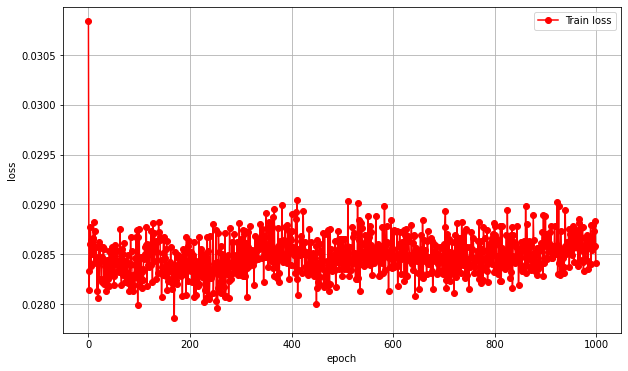

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
minloss=float('inf')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#导入数据
#划分测试集和训练集
df_train= pd.read_csv('/kolla/ysy/all/all.csv')
x = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1).values
y = df_train['logerror'].values
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
#标准化处理
scale=StandardScaler()
X_train_s=scale.fit_transform(X_train)
X_test_s=scale.fit_transform(X_test)



#将数据集转化为张量 并处理为PyTorch网络使用的数据
train_xt=torch.from_numpy(X_train_s.astype(np.float32))
train_yt=torch.from_numpy(y_train.astype(np.float32))
test_xt=torch.from_numpy(X_test_s.astype(np.float32))
test_yt=torch.from_numpy(y_test.astype(np.float32))
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)
train_loader=Data.DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)

# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=44, out_features=880, bias=True),
                                  nn.Dropout(0.3),
                                  nn.Tanh()
                                  )
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=880, out_features=220, bias=True),
                                  nn.Dropout(0.3),
                                  nn.Tanh()
                                  )
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=220, out_features=44, bias=True),
                                  nn.Dropout(0.3),
                                  nn.Tanh()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=44, out_features=1, bias=True),
                                        nn.Tanh())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output[:, 0]


mlpreg=MLP().to(device)
print(mlpreg)
#定义优化器
optimizer=torch.optim.Adam(mlpreg.parameters(),lr=0.01)
loss_func=nn.MSELoss()
train_loss_all=[]
for epoch in range(1000):
    train_loss=0
    train_num=0
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x.to(device))
        # print(output,b_y)
        loss=loss_func(output.to(device),b_y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    train_loss_all.append(train_loss/train_num)
    if epoch%10 == 0:
        print(f'train: Epo:{epoch}  Loss :{loss}')
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()



[-0.004   0.006  -0.0284 ...  0.0469  0.5218  0.0392]
******
[-0.09047893 -0.12712136  0.04508157 ... -0.09047893 -0.11693984
 -0.09047893]
0.03206797823401985


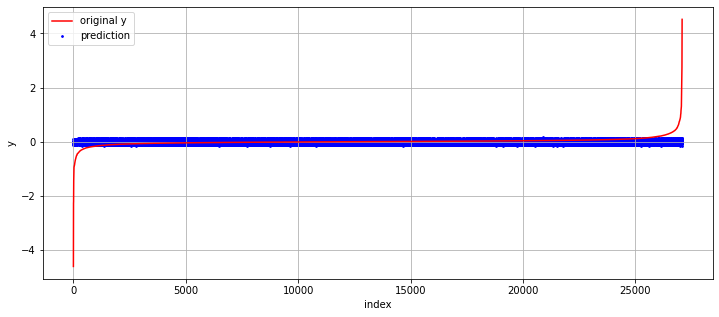

In [22]:
# 测试集
# nn.LeakyReLU()
#预测  
mlpreg.eval().to(device)
pre_y=mlpreg(test_xt.to(device))
pre_y=pre_y.data.cpu().numpy()
print(y_test)
print('******')
print(pre_y)
mae=mean_squared_error(y_test,pre_y)
print(mae)
index=np.argsort(test_yt)
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(y_test)),y_test[index],"r",label="original y")
plt.scatter(np.arange(len(pre_y)),pre_y[index],s=3,c="b",label="prediction")
plt.legend(loc="upper left")
plt.grid()
plt.xlabel("index")
plt.ylabel("y")
plt.show()